In [ ]:
# Copyright © 2023 Samee Manidhar

# New Vehicle Sales Forecast in Canada!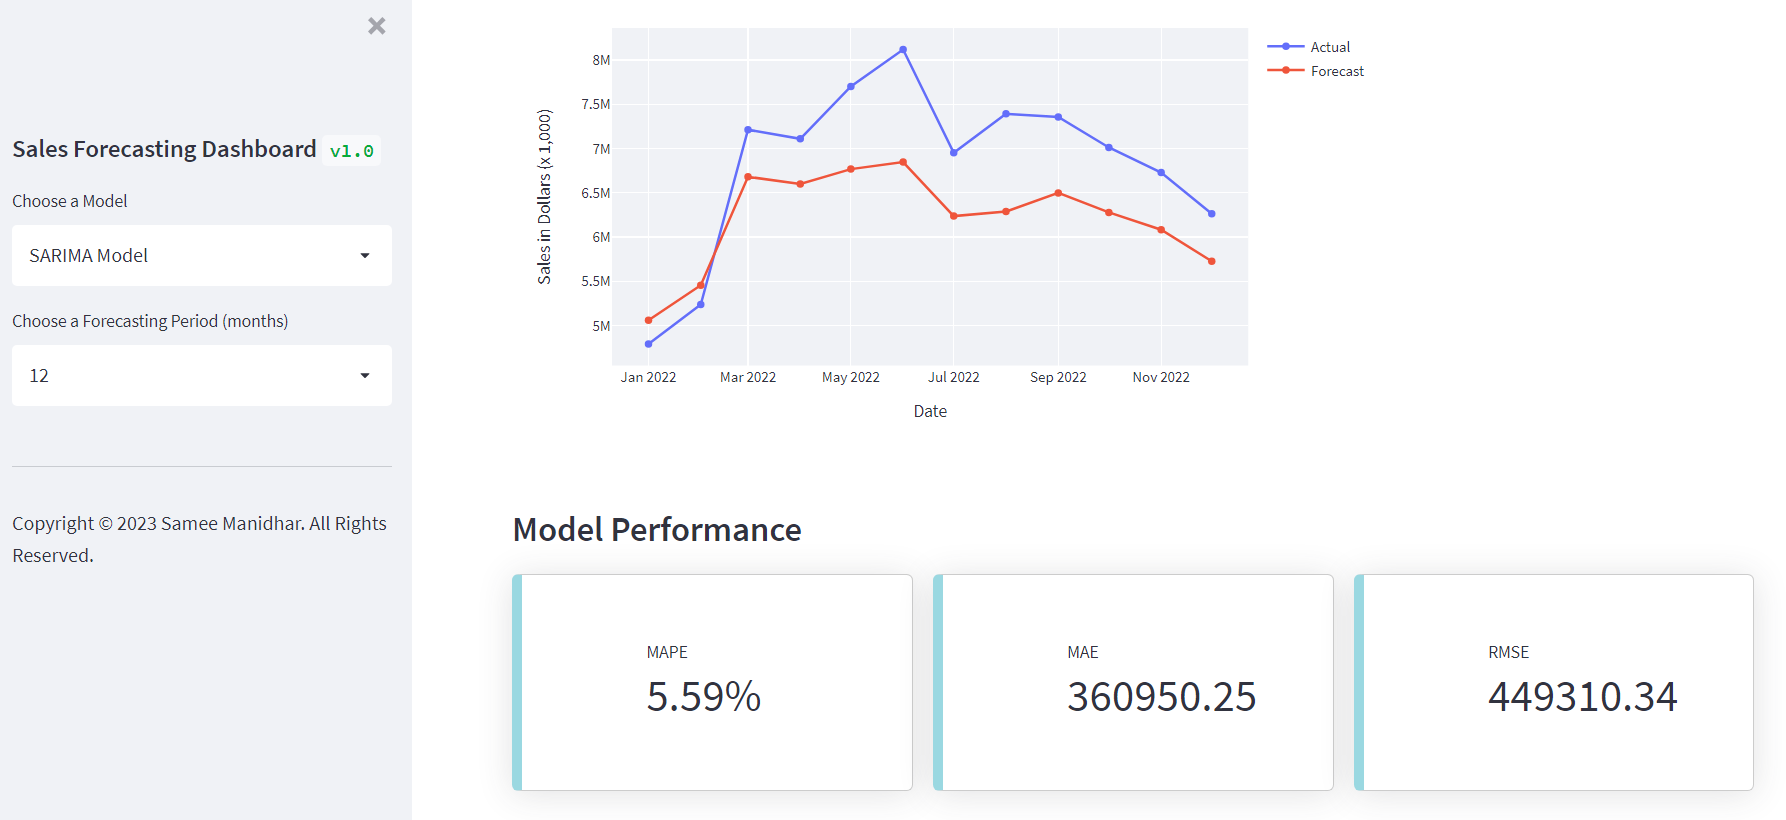

The automotive industry is a substantial contributor to the global economy, and accurate forecasting of new motor vehicle sales is fundamental for stakeholders to make informed business decisions.

The purpose of this project is to create a prediction model that accurately predicts new car sales using statistical methodologies and machine learning algorithms.

Seasonal demands, monthly gas prices, interest rates, unemployment rates, and natural disasters can gravely impact the sales if companies are not aware of the trends and hence prepared for them.

Sales forecasting will therefore help companies anticipate the market trends and arrange their catalogue, calculate the revenue, as well as decide on new investments.

## Dashboard

As an end to end project, a fully functional dashboard using these models was created and deployed. The dashboard can be accessed by clicking the link below.

[Sales Forecast Dashboard](https://sales-forecasting-dashboard-sm.streamlit.app)

The interactive dashboard was created using streamlit and python. It offers a comprehensive analysis of historical new vehicle sales data, along with predictive insights for future sales trends in Canada. The dashboard helps in comparing and visualizing the different models.


## Dataset

The dataset of new motor vehicles sales in Canada from Jan 2000 - Dec 2022 was collected. Other dependecies like mean temperature, precipitation, ground frost days, unemployment rate, employment rate, gdp, gdp - motor industry, gas prices and cpi of entire Canada was also collected. Since the vehicle sales dataset was monthly frequency, we had to ensure that the rest of the dependencies were also in monthly frequency from the same range.

The dataset was collected from: https://www150.statcan.gc.ca
https://www.uea.ac.uk/groups-and-centres/climatic-research-unit

This timed series dataset can be utilized to perform exploratory data analysis as well as the primary project objective.

### Import Libraries

In [32]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objs as go
from plotly.offline import iplot
import plotly.express as px
import statsmodels
import sklearn
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
import os
import pathlib

#### Define Path

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
path = '/content/drive/MyDrive/NVSalesForecast-Dataset/finaldata.csv'
d_dir = pathlib.Path(path)

df = pd.read_csv(path, index_col = 'Month_No')

### Dataset

In [5]:
# Creating a table using Plotly with DataFrame (df)
trace = go.Table(
    header=dict(values=df.columns),
    cells=dict(values=[df[col] for col in df.columns])
)

layout = go.Layout(title='NVSF - Dataset')
fig = go.Figure(data=[trace], layout=layout)

# Display the Plotly table in Colab using iplot
iplot(fig)

## Exploratory Data Analysis

Exploratory Data Analysis (EDA) serves as the stepping stone in comprehending the dataset gathered for the project. This approach involves assessment of dataset structure, statistical summaries, and inherent attributes specific to the industry. By employing data visualization, statistical analysis, and pattern recognition, we can reveal nuanced trends, anomalies, and correlations within variables.

Through EDA, we discern critical facets including sales distributions, temporal patterns, correlations between sales and various predictors such as temperature, precipitation, economic indicators, and more. It enables the identification of outliers or missing data, pivotal for data cleaning and preprocessing.

Insights from this phase serve as the bedrock for hypothesis formulation and the strategic selection of predictive models. Considering this is a Time Series Dataset we have a basic understanding of the types of models to choose.

By investigating the dataset through EDA, we establish an initial comprehension of intricate patterns and relationships, laying the groundwork for informed modeling strategies and the subsequent development of an accurate forecasting model for new vehicle sales in the Canadian market.

### Correlation Matrix

In [9]:
# Create a heatmap trace
heatmap_trace = go.Heatmap(
    z=df.corr(),  # Use correlation matrix as heatmap values
    x=df.columns,  # X-axis labels
    y=df.columns,  # Y-axis labels
    colorscale='Viridis'  # Color scheme
)

# Create a layout
layout = go.Layout(
    title='Correlation Matrix Heatmap',
    xaxis=dict(title='Variables'),
    yaxis=dict(title='Variables'),
    height=650,  # Set the height of the figure
    width=1000,  # Set the width of the figure
)

# Create a figure and add the heatmap trace and layout
hm = go.Figure(data=[heatmap_trace], layout=layout)

iplot(hm)

### Box Plot

In [13]:
# Create a boxplot
bx = px.box(df, y="Dollars  (x 1,000)", points="all", title="Sales Distribution - Box Plot",
            orientation="h", labels={'Dollars  (x 1,000)': 'Sales Amount'})

bx.update_traces(marker=dict(color='skyblue', size=4))  # Update marker properties for better visibility
bx.update_layout(xaxis=dict(title='Sales Amount'), yaxis=dict(title=''))  # Customize axes labels
bx.show()

bx = px.box(df, y="Dollars  (x 1,000)", title="Box Plot Sales")
bx.show()

### Sales Impact by Correlated Factors

In [18]:
# Bar plot - Sales by GDP
b1 = px.bar(df, x="GDP All Industries - base price (x1000000)", y="Dollars  (x 1,000)",
            title="Sales by GDP All Industries", color='Dollars  (x 1,000)',
            color_continuous_scale='darkmint')
b1.show()

# Bar plot - Sales by CPI
b2 = px.bar(df, x="CPI - All items", y="Dollars  (x 1,000)",
            title="Sales by CPI - All Items", color='Dollars  (x 1,000)',
            color_continuous_scale='magenta')
b2.show()

# Bar plot - Sales by Gas
b3 = px.bar(df, x="Gas Price Reg Unleaded - monthly (cents/litre)", y="Dollars  (x 1,000)",
            title="Sales by Gas Price Reg Unleaded (c/l)", color='Dollars  (x 1,000)',
            color_continuous_scale='emrld')
b3.show()

# Bar plot - Sales by Unemployment Rate
b4 = px.bar(df, x="Unemployment Rate (15 years and over)", y="Dollars  (x 1,000)",
            title="Sales by Unemployment Rate (15 years and over)", color='Dollars  (x 1,000)',
            color_continuous_scale='burg')
b4.show()

# Bar plot - Sales by Mean Temperature (°C)
b5 = px.bar(df, x="Mean Temperature (°C)", y="Dollars  (x 1,000)",
            title="Sales by Mean Temperature (°C)", color='Dollars  (x 1,000)',
            color_continuous_scale='ylgnbu')
b5.show()

### Sales over Time

In [20]:
# Fit a trend line
z = np.polyfit(df.index, df['Dollars  (x 1,000)'], 1)
p = np.poly1d(z)

# Plotly line plot
fig = go.Figure()

# Scatter plot for sales over time
fig.add_trace(go.Scatter(x=df.index, y=df['Dollars  (x 1,000)'], mode='lines', name='Sales over Time'))

# Trend line
fig.add_trace(go.Scatter(x=df.index, y=p(df.index), mode='lines', name='Trend', line=dict(dash='dash', color='red')))

# Update layout
fig.update_layout(
    title='Sales over Time',
    xaxis_title='Month Number',
    yaxis_title='Dollars  (x 1,000)',
    height=500,
    width=800
)

fig.show()

## Training Data

In [23]:
# Create a date range starting from January 2000 to March 2023 with a monthly frequency
dates = pd.date_range(start='2000-01-01', end='2022-12-01', freq='MS')

# Set the date range as the index of the DataFrame
df.set_index(dates, inplace=True)

# Define the training data
train_size = int(len(df) * 0.75)
X = df.drop('Dollars  (x 1,000)', axis=1)
y = df['Dollars  (x 1,000)']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, shuffle=False)

## Machine Learning Models

In [24]:
# Define functions for models
def mlr_model(X_train, y_train, X_test, y_test):
    mlr = LinearRegression()
    mlr.fit(X_train, y_train)
    y_test = y_test
    y_pred = mlr.predict(X_test)
    return y_pred, y_test

def arima_model(X_train, y_train, X_test, y_test):
    arima = ARIMA(y_test, order=(1, 0, 2))
    arima_fit = arima.fit()
    actual = y_test[0:69]
    y_pred = arima_fit.predict(exog=X_test)
    forecast = y_pred[0:69]
    return forecast, actual

def sarima_model(X_train, y_train, X_test, y_test):
    sarima = SARIMAX(y_train, order=(1, 1, 0), seasonal_order=(0, 0, 1, 12), exog=X_train)
    sarima_fit = sarima.fit()
    actual = y_test[0:69]
    y_pred = sarima_fit.predict(start=len(y_train), end=len(y_train)+len(y_test)-1, exog=X_test)
    forecast = y_pred[0:69]
    return forecast, actual

def dt_model(X_train, y_train, X_test, y_test):
    dt = DecisionTreeRegressor(splitter='random', criterion='absolute_error', max_depth=None, min_samples_leaf=2, min_impurity_decrease=0.0001, min_samples_split=5, max_features=None, random_state=0)
    dt.fit(X_train, y_train)
    y_test = y_test
    y_pred = dt.predict(X_test)
    return y_pred, y_test

def rf_model(X_train, y_train, X_test, y_test):
    rfr = RandomForestRegressor(criterion='friedman_mse', bootstrap=False, n_estimators=1000, max_depth=None, min_samples_leaf=2, min_samples_split=2, max_features='sqrt', random_state=42)
    rfr.fit(X_train, y_train)
    y_test = y_test
    y_pred = rfr.predict(X_test)
    return y_pred, y_test

#### Multivariate Linear Regression Model

In [43]:
# MLR Model
y_pred, y_test = mlr_model(X_train, y_train, X_test, y_test)
actual = pd.DataFrame({"Date": y[train_size:].index,"Sales": y_test})
actual = actual.tail(12)
forecast = pd.DataFrame({"Date": y[train_size:].index,"Sales": y_pred})
forecast = forecast.tail(12)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
MLR_acc = 100 - mape

# Plotting actual vs. forecasted sales
fig = go.Figure()

# Add actual sales data
fig.add_trace(go.Scatter(x=actual['Date'], y=actual['Sales'], mode='lines', name="Actual"))

# Add forecasted sales data
fig.add_trace(go.Scatter(x=forecast['Date'], y=forecast['Sales'], mode='lines', name="Forecast"))

# Update layout
fig.update_layout(
    title="Actual vs. Forecasted Sales",
    xaxis_title="Month",
    yaxis_title="Sales in Dollars (x 1,000)"
)

# Show the plot
fig.show()

# Display model performance metrics
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}%")

RMSE: 955411.8481003636
MAE: 855361.4539544281
MAPE: 12.147140187343227%


#### ARIMA Model

In [44]:
# ARIMA Model
y_pred, y_test = arima_model(X_train, y_train, X_test, y_test)
actual = pd.DataFrame({"Date": y[train_size:].index,"Sales": y_test})
actual = actual.tail(12)
forecast = pd.DataFrame({"Date": y[train_size:].index, "Sales": y_pred})
forecast = forecast.tail(12)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
A_acc = 100 - mape

# Plotting actual vs. forecasted sales
fig = go.Figure()

# Add actual sales data
fig.add_trace(go.Scatter(x=actual['Date'], y=actual['Sales'], mode='lines', name="Actual"))

# Add forecasted sales data
fig.add_trace(go.Scatter(x=forecast['Date'], y=forecast['Sales'], mode='lines', name="Forecast"))

# Update layout
fig.update_layout(
    title="ARIMA Actual vs. Forecasted Sales",
    xaxis_title="Month",
    yaxis_title="Sales in Dollars (x 1,000)"
)

# Show the plot
fig.show()

# Display model performance metrics
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}%")

RMSE: 878489.7232835826
MAE: 653251.3089306813
MAPE: 11.04671913028134%


#### SARIMA Model

In [45]:
# SARIMA Model
y_pred, y_test = sarima_model(X_train, y_train, X_test, y_test)
actual = pd.DataFrame({"Date": y[train_size:].index,"Sales": y_test})
actual = actual.tail(12)
forecast = pd.DataFrame({"Date": y[train_size:].index,"Sales": y_pred})
forecast = forecast.tail(12)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
S_acc = 100 - mape

# Plotting actual vs. forecasted sales
fig = go.Figure()

# Add actual sales data
fig.add_trace(go.Scatter(x=actual['Date'], y=actual['Sales'], mode='lines', name="Actual"))

# Add forecasted sales data
fig.add_trace(go.Scatter(x=forecast['Date'], y=forecast['Sales'], mode='lines', name="Forecast"))

# Update layout
fig.update_layout(
    title="SARIMA Actual vs. Forecasted Sales",
    xaxis_title="Month",
    yaxis_title="Sales in Dollars (x 1,000)"
)

# Show the plot
fig.show()

# Display model performance metrics
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}%")

RMSE: 449310.34439200046
MAE: 360950.2545098992
MAPE: 5.588229033026948%


#### Decision Tree Model

In [46]:
# DT Model
y_pred, y_test = dt_model(X_train, y_train, X_test, y_test)
actual = pd.DataFrame({"Date": y[train_size:].index,"Sales": y_test})
actual = actual.tail(12)
forecast = pd.DataFrame({"Date": y[train_size:].index,"Sales": y_pred})
forecast = forecast.tail(12)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
DT_acc = 100 - mape

# Plotting actual vs. forecasted sales
fig = go.Figure()

# Add actual sales data
fig.add_trace(go.Scatter(x=actual['Date'], y=actual['Sales'], mode='lines', name="Actual"))

# Add forecasted sales data
fig.add_trace(go.Scatter(x=forecast['Date'], y=forecast['Sales'], mode='lines', name="Forecast"))

# Update layout
fig.update_layout(
    title="DT Actual vs. Forecasted Sales",
    xaxis_title="Month",
    yaxis_title="Sales in Dollars (x 1,000)"
)

# Show the plot
fig.show()

# Display model performance metrics
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}%")

RMSE: 1050524.1574060745
MAE: 900995.5289855072
MAPE: 12.783489795559177%


#### Random Forest Model

In [47]:
# RF Model
y_pred, y_test = rf_model(X_train, y_train, X_test, y_test)
actual = pd.DataFrame({"Date": y[train_size:].index,"Sales": y_test})
actual = actual.tail(12)
forecast = pd.DataFrame({"Date": y[train_size:].index,"Sales": y_pred})
forecast = forecast.tail(12)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
RF_acc = 100 - mape

# Plotting actual vs. forecasted sales
fig = go.Figure()

# Add actual sales data
fig.add_trace(go.Scatter(x=actual['Date'], y=actual['Sales'], mode='lines', name="Actual"))

# Add forecasted sales data
fig.add_trace(go.Scatter(x=forecast['Date'], y=forecast['Sales'], mode='lines', name="Forecast"))

# Update layout
fig.update_layout(
    title="RF Actual vs. Forecasted Sales",
    xaxis_title="Month",
    yaxis_title="Sales in Dollars (x 1,000)"
)

# Show the plot
fig.show()

# Display model performance metrics
print(f"RMSE: {rmse}")
print(f"MAE: {mae}")
print(f"MAPE: {mape}%")

RMSE: 1112720.7331882042
MAE: 969367.7847850232
MAPE: 14.192363898190283%


## Model Summary

In [49]:
# Model Accuracy
print(f"MLR: {MLR_acc}")
print(f"ARIMA: {A_acc}")
print(f"SARIMA: {S_acc}")
print(f"DT: {DT_acc}")
print(f"RF: {RF_acc}%")

MLR: 87.85285981265677
ARIMA: 88.95328086971865
SARIMA: 94.41177096697305
DT: 87.21651020444082
RF: 85.80763610180972%


The statistical as expected, performed better than the rest since the dataset is time-series. SARIMA had an accuracy of 94.4 % followed by ARIMA with 89 %.  A fully functional dashboard can be accessed to compare the models more clearly.

(https://sales-forecasting-dashboard-sm.streamlit.app)